In [1]:
import torch
import torch.optim as optim
import torch.utils.data
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#--- hyperparameters ---
N_EPOCHS = 2
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 100
LR = 0.005

In [3]:
#--- fixed constants ---
NUM_CLASSES = 24
DATA_DIR = '../data/sign_mnist_%s'

In [4]:
# --- Dataset initialization ---

# We transform image files' contents to tensors
# Plus, we can add random transformations to the training data if we like
# Think on what kind of transformations may be meaningful for this data.
# Eg., horizontal-flip is definitely a bad idea for sign language data.
# You can use another transformation here if you find a better one.

# Grayscale + toTensor + Normalize
train_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=0.5, std=0.5, inplace=True)])

test_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=0.5, std=0.5, inplace=True)])

train_set = datasets.ImageFolder(DATA_DIR % 'train', transform=train_transform)
dev_set   = datasets.ImageFolder(DATA_DIR % 'dev',   transform=test_transform)
test_set  = datasets.ImageFolder(DATA_DIR % 'test',  transform=test_transform)


# Create Pytorch data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dataset=dev_set, batch_size=len(dev_set), shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE_TEST, shuffle=False)

In [5]:
#--- model ---
class CNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()
        # WRITE CODE HERE
        
        # Sequential 1: Convolution + batch normalization + ReLU + maxpooling
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=100, kernel_size=3, stride=1),
            nn.BatchNorm2d(num_features=100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        
        # Sequential 2: Convolution + batch normalization + ReLU + maxpooling
        self.seq2 = nn.Sequential(
            nn.Conv2d(in_channels=100, out_channels=80, kernel_size=5, stride=1),
            nn.BatchNorm2d(num_features=80),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4, padding=0))
        
        # Sequential 3: Linear + ReLU + Linear
        self.seq3 = nn.Sequential(
            nn.Linear(in_features=4*80, out_features=250),
            nn.ReLU(),
            nn.Linear(in_features=250, out_features=NUM_CLASSES))
            
    def forward(self, x):
        # WRITE CODE HERE
  
        # Sequential 1
        x = self.seq1(x)
        
        # Sequential 2
        x = self.seq2(x)
        
        # Reshape
        x = x.view(x.size(0), -1)
        
        # Sequential 3
        x = self.seq3(x)
        
        # log_softmax
        x = F.log_softmax(x, dim=1)
        
        # Return x
        return x

# Print model summary
#print(CNN())

In [6]:
#--- set up ---

# Print Cuda info
print("Cuda is available: {} \n".format(torch.cuda.is_available()))


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model = CNN().to(device)

# WRITE CODE HERE

# Oprimizers
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Loss functions
loss_function = nn.CrossEntropyLoss()

# Make empty dev lost list and add start values 0 to list
# When done=True, then end training
dev_loss_list = []
train_loss_list = []
dev_loss_list.append(100)
dev_loss_list.append(100)
dev_loss_list.append(100)
done = False
counter = 0

Cuda is available: False 



Training: Epoch 0 - Batch 0/275: Loss: 3.2005 | Train Acc: 6.000% (6/100)

Dev loss 3.7409 % 

Training: Epoch 0 - Batch 1/275: Loss: 3.4217 | Train Acc: 5.500% (11/200)
Training: Epoch 0 - Batch 2/275: Loss: 3.3522 | Train Acc: 5.667% (17/300)
Training: Epoch 0 - Batch 3/275: Loss: 3.2969 | Train Acc: 7.000% (28/400)
Training: Epoch 0 - Batch 4/275: Loss: 3.2393 | Train Acc: 8.800% (44/500)
Training: Epoch 0 - Batch 5/275: Loss: 3.2079 | Train Acc: 9.667% (58/600)
Training: Epoch 0 - Batch 6/275: Loss: 3.1658 | Train Acc: 10.000% (70/700)
Training: Epoch 0 - Batch 7/275: Loss: 3.1274 | Train Acc: 11.250% (90/800)
Training: Epoch 0 - Batch 8/275: Loss: 3.0867 | Train Acc: 11.111% (100/900)
Training: Epoch 0 - Batch 9/275: Loss: 3.0653 | Train Acc: 11.700% (117/1000)
Training: Epoch 0 - Batch 10/275: Loss: 3.0243 | Train Acc: 12.909% (142/1100)

Dev loss 2.64571 % 

Training: Epoch 0 - Batch 11/275: Loss: 2.9765 | Train Acc: 14.167% (170/1200)
Training: Epoch 0 - Batch 12/275: Loss: 2.9


Dev loss 0.29186 % 

Training: Epoch 0 - Batch 101/275: Loss: 0.9934 | Train Acc: 69.549% (7094/10200)
Training: Epoch 0 - Batch 102/275: Loss: 0.9854 | Train Acc: 69.777% (7187/10300)
Training: Epoch 0 - Batch 103/275: Loss: 0.9765 | Train Acc: 70.058% (7286/10400)
Training: Epoch 0 - Batch 104/275: Loss: 0.9683 | Train Acc: 70.305% (7382/10500)
Training: Epoch 0 - Batch 105/275: Loss: 0.9603 | Train Acc: 70.566% (7480/10600)
Training: Epoch 0 - Batch 106/275: Loss: 0.9520 | Train Acc: 70.822% (7578/10700)
Training: Epoch 0 - Batch 107/275: Loss: 0.9441 | Train Acc: 71.065% (7675/10800)
Training: Epoch 0 - Batch 108/275: Loss: 0.9363 | Train Acc: 71.312% (7773/10900)
Training: Epoch 0 - Batch 109/275: Loss: 0.9285 | Train Acc: 71.573% (7873/11000)
Training: Epoch 0 - Batch 110/275: Loss: 0.9208 | Train Acc: 71.820% (7972/11100)

Dev loss 0.27392 % 

Training: Epoch 0 - Batch 111/275: Loss: 0.9133 | Train Acc: 72.054% (8070/11200)
Training: Epoch 0 - Batch 112/275: Loss: 0.9059 | Trai

Training: Epoch 0 - Batch 198/275: Loss: 0.5247 | Train Acc: 84.151% (16746/19900)
Training: Epoch 0 - Batch 199/275: Loss: 0.5221 | Train Acc: 84.230% (16846/20000)
Training: Epoch 0 - Batch 200/275: Loss: 0.5195 | Train Acc: 84.308% (16946/20100)

Dev loss 0.14663 % 

Training: Epoch 0 - Batch 201/275: Loss: 0.5169 | Train Acc: 84.386% (17046/20200)
Training: Epoch 0 - Batch 202/275: Loss: 0.5145 | Train Acc: 84.463% (17146/20300)
Training: Epoch 0 - Batch 203/275: Loss: 0.5120 | Train Acc: 84.539% (17246/20400)
Training: Epoch 0 - Batch 204/275: Loss: 0.5095 | Train Acc: 84.615% (17346/20500)
Training: Epoch 0 - Batch 205/275: Loss: 0.5070 | Train Acc: 84.689% (17446/20600)
Training: Epoch 0 - Batch 206/275: Loss: 0.5046 | Train Acc: 84.763% (17546/20700)
Training: Epoch 0 - Batch 207/275: Loss: 0.5022 | Train Acc: 84.837% (17646/20800)
Training: Epoch 0 - Batch 208/275: Loss: 0.4998 | Train Acc: 84.909% (17746/20900)
Training: Epoch 0 - Batch 209/275: Loss: 0.4975 | Train Acc: 84.9

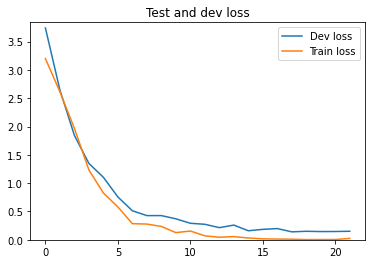

[3.7409000396728516, 2.645712375640869, 1.8438059091567993, 1.3484294414520264, 1.103895664215088, 0.7563544511795044, 0.5127657055854797, 0.42748793959617615, 0.42745742201805115, 0.37073689699172974, 0.2918638288974762, 0.2739216387271881, 0.21479246020317078, 0.2598567008972168, 0.15966174006462097, 0.18474546074867249, 0.19830875098705292, 0.1404963582754135, 0.15043875575065613, 0.14540815353393555, 0.1466323882341385, 0.15082032978534698]


In [7]:
#--- training ---

for epoch in range(N_EPOCHS):
    
    # If done=True, stop training
    if done:
        break
        
    # Initialize values
    train_loss = 0
    train_correct = 0
    total = 0
    
    for batch_num, (data, target) in enumerate(train_loader):
        
        # If done=True, stop training
        if done:
            break
            
        # Get data and target
        data, target = data.to(device), target.to(device)
            
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Sum of sizes
        total += target.size(0)
        
        # Get prediction values
        outputs = model(data)
        
        # Get prediction labels
        _, predicted = torch.max(outputs, 1)
        
        # Sum of number of correct predictions
        train_correct += (predicted == target).sum().item()
        
        # Calculate loss
        loss=loss_function(outputs, target)
        
        # Backward + optimizer step
        loss.backward()
        optimizer.step()

        # Print statistics
        train_loss+=loss
        print('Training: Epoch %d - Batch %d/%d: Loss: %.4f | Train Acc: %.3f%% (%d/%d)' % 
              (epoch, batch_num, len(train_loader), train_loss / (batch_num + 1), 
               100. * train_correct / total, train_correct, total))
        
# -- Check development set accuracy and stop training if it start to decline

    # WRITE CODE HERE
    # Please implement early stopping here.
    # You can try different versions, simplest way is to calculate the dev error and
    # compare this with the previous dev error, stopping if the error has grown.

    
    # In the early stopping we compare latest dev loss to previous last 3 dev losses
    # To make training more efficiont, we will compute dev loss once in every 10 epochs
    # If latest dev loss is larger than all previous 3, then end training
        if (counter%10 == 0):
            train_loss_list.append(float(loss))
            for dev_batch_num, (dev_data, dev_target) in enumerate(dev_loader):
                dev_data, dev_target = dev_data.to(device), dev_target.to(device)
                dev_outputs = model(dev_data)
                _, dev_predicted = torch.max(dev_outputs, 1)   
                dev_loss=loss_function(dev_outputs, dev_target)
                dev_loss = float(dev_loss)      
                print("\nDev loss {} % \n".format(round(dev_loss, 5)))
                
                # Save dev loss to list
                dev_loss_list.append(dev_loss)
        
                # If the latest dev correct accuracy is smaller than the last 3 values, then end training
                dev_last_three = dev_loss_list[-4:-1]
                if all(dev_prev_loss < dev_loss for dev_prev_loss in dev_last_three):
                    print("Dev accuracy declining. Activate early stopping. \n")
                    done = True
                    break
    
        # Add 1 to counter
        counter = counter+1

# Remove initialized first three 0 values from dev_correct_list
dev_loss_list = dev_loss_list[3:]

# Plot dev correct
plt.plot(dev_loss_list, label = "Dev loss")
plt.plot(train_loss_list, label = "Train loss")
plt.ylim((0, max(dev_loss_list+train_loss_list)+0.1))
plt.title("Test and dev loss")
plt.legend()
plt.show()

# Print dev_accuracy_list
print(dev_loss_list)

In [8]:
#--- test ---
test_loss = 0
test_correct = 0
total = 0

with torch.no_grad():
    for batch_num, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        # WRITE CODE HERE
        outputs=model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        test_correct += (predicted == target).sum()
        loss=loss_function(outputs, target)
        
        test_loss+=loss
        print('Evaluating: Batch %d/%d: Loss: %.4f | Test Acc: %.3f%% (%d/%d)' % 
              (batch_num, len(test_loader), test_loss / (batch_num + 1), 
               100. * test_correct / total, test_correct, total))


Evaluating: Batch 0/37: Loss: 0.3396 | Test Acc: 87.000% (87/100)
Evaluating: Batch 1/37: Loss: 0.2432 | Test Acc: 90.500% (181/200)
Evaluating: Batch 2/37: Loss: 0.8742 | Test Acc: 76.667% (230/300)
Evaluating: Batch 3/37: Loss: 1.0289 | Test Acc: 73.000% (292/400)
Evaluating: Batch 4/37: Loss: 1.0428 | Test Acc: 73.200% (366/500)
Evaluating: Batch 5/37: Loss: 0.8765 | Test Acc: 77.667% (466/600)
Evaluating: Batch 6/37: Loss: 0.7907 | Test Acc: 79.714% (558/700)
Evaluating: Batch 7/37: Loss: 0.7015 | Test Acc: 81.750% (654/800)
Evaluating: Batch 8/37: Loss: 0.6304 | Test Acc: 83.444% (751/900)
Evaluating: Batch 9/37: Loss: 0.5683 | Test Acc: 85.100% (851/1000)
Evaluating: Batch 10/37: Loss: 0.5305 | Test Acc: 86.273% (949/1100)
Evaluating: Batch 11/37: Loss: 0.7105 | Test Acc: 83.500% (1002/1200)
Evaluating: Batch 12/37: Loss: 0.8046 | Test Acc: 81.615% (1061/1300)
Evaluating: Batch 13/37: Loss: 0.8925 | Test Acc: 79.857% (1118/1400)
Evaluating: Batch 14/37: Loss: 0.8601 | Test Acc: 8